In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
import random

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Stratified sampling for multi-label classification
from skmultilearn.model_selection import IterativeStratification

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Transformers
import torch
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.utils.data import Dataset, DataLoader
import transformers 
from transformers import LongformerModel, LongformerTokenizerFast, LongformerConfig, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers.models.longformer.modeling_longformer import LongformerPreTrainedModel, LongformerClassificationHead

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [4]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [5]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth one world leading online betting gaming company org...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [6]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [7]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes], y[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.2)

## 2. Simple method: Feed Longformer embeddings into classifier

### 2.1. Compute embeddings with pre-trained Longformer model

In [8]:
# Use GPU
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [9]:
# Load model and tokenizer
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Inference (use GPU)

# Training data

input_data = list(X_train)
outputs_train = np.zeros((len(input_data), 768))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")
    # Add global attention mask on <s> token (equivalent to [CLS])
    global_attention_mask = torch.zeros_like(tokenized_sentence['input_ids'])
    global_attention_mask[:, 0] = 1
    tokenized_sentence["global_attention_mask"] = global_attention_mask
    with torch.no_grad():
        # Compute embeddings for batch
        last_hidden_states = model(**tokenized_sentence.to(device))
    # Store [CLS] tokens
    outputs_train[i:i+1] = last_hidden_states[0][:,0,:].cpu().numpy()
    i += 1

# Test data
input_data = list(X_test)
outputs_test = np.zeros((len(input_data), 768))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")
    # Add global attention mask on <s> token (equivalent to [CLS])
    global_attention_mask = torch.zeros_like(tokenized_sentence['input_ids'])
    global_attention_mask[:, 0] = 1
    tokenized_sentence["global_attention_mask"] = global_attention_mask
    with torch.no_grad():
        # Compute embeddings for batch
        last_hidden_states = model(**tokenized_sentence.to(device))
    # Store [CLS] tokens
    outputs_test[i:i+1] = last_hidden_states[0][:,0,:].cpu().numpy()
    i += 1

  0%|          | 0/6249 [00:00<?, ?it/s]

  0%|          | 0/1892 [00:00<?, ?it/s]

### 2.2. Classification (no prior balancing of data)

In [11]:
# Train Logistic Regression Classifier
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(outputs_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression())

              precision    recall  f1-score   support

           0       0.67      0.18      0.29       198
           1       0.81      0.98      0.88      1499
           2       0.77      0.97      0.86      1442
           3       0.74      0.96      0.84      1314
           4       0.78      0.93      0.85      1414
           5       0.74      0.89      0.81      1317
           6       0.71      0.91      0.80      1220
           7       0.55      0.14      0.22       191
           8       0.83      0.98      0.90      1544
           9       0.69      0.82      0.75      1151
          10       0.54      0.49      0.52       559
          11       0.71      0.93      0.81      1248
          12       0.55      0.14      0.22       191

   micro avg       0.75      0.88      0.81     13288
   macro avg       0.70      0.72      0.67     13288
weighted avg       0.74      0.88      0.80     13288
 samples avg       0.74      0.88      0.78     13288



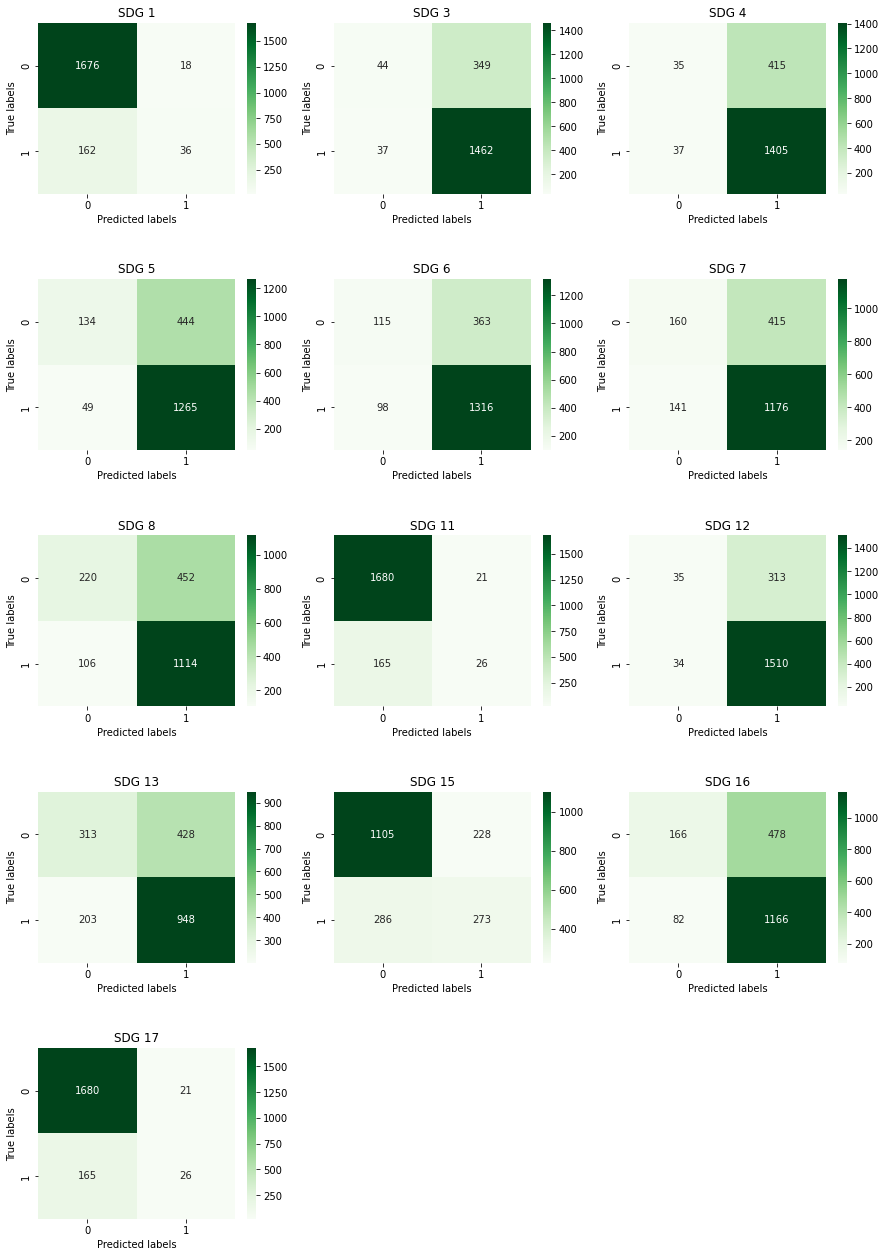

In [12]:
evaluation(clf, outputs_test, Y_test)

              precision    recall  f1-score   support

           0       0.57      0.14      0.22       198
           1       0.79      0.99      0.88      1499
           2       0.77      0.99      0.87      1442
           3       0.73      0.98      0.83      1314
           4       0.79      0.97      0.87      1414
           5       0.74      0.92      0.82      1317
           6       0.70      0.94      0.80      1220
           7       0.52      0.12      0.19       191
           8       0.82      1.00      0.90      1544
           9       0.70      0.84      0.76      1151
          10       0.68      0.52      0.58       559
          11       0.70      0.94      0.80      1248
          12       0.52      0.12      0.19       191

   micro avg       0.75      0.90      0.82     13288
   macro avg       0.70      0.73      0.67     13288
weighted avg       0.74      0.90      0.80     13288
 samples avg       0.74      0.90      0.79     13288



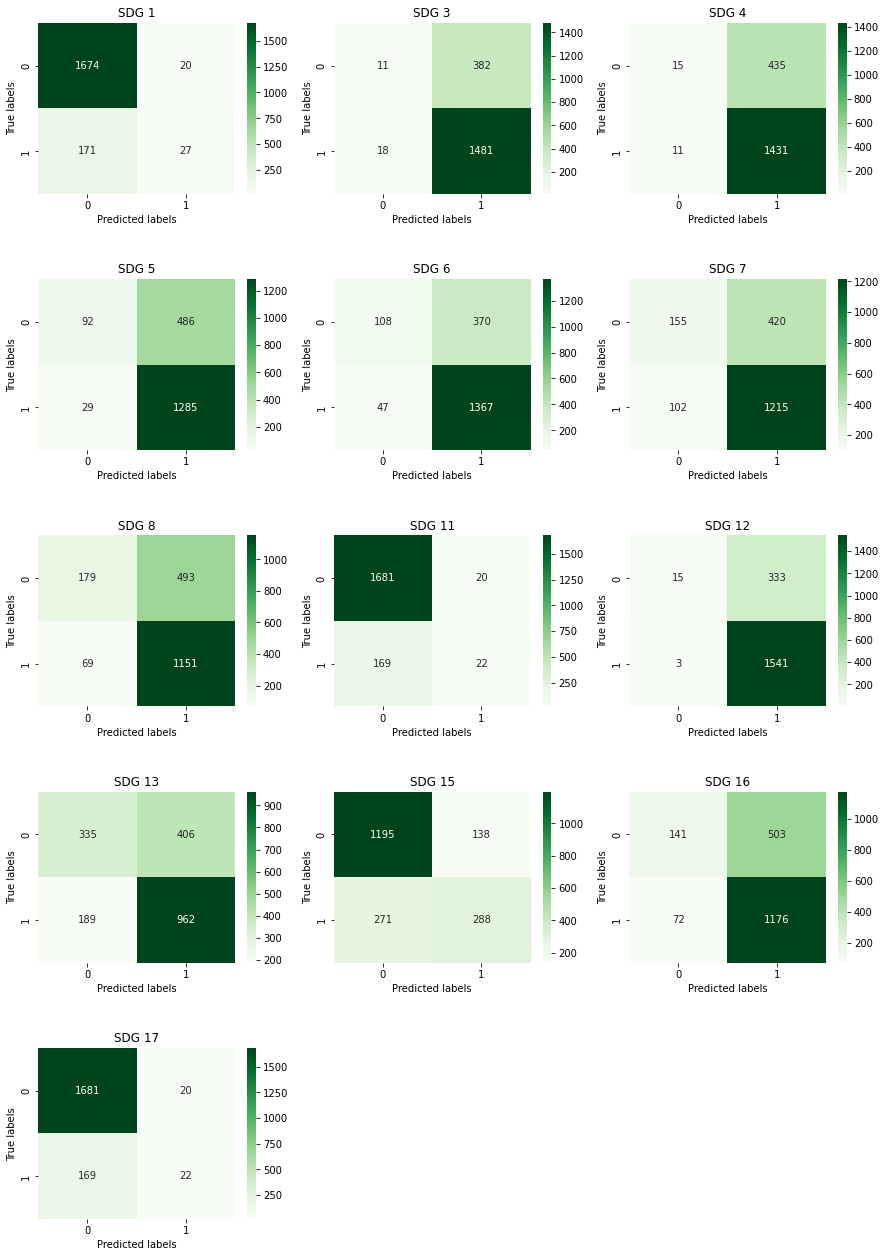

In [16]:
# Evaluation tokenized
evaluation(clf, outputs_test, Y_test)

### 2.3. Classification with balanced weights

In [13]:
# Train Logistic Regression Classifier
clf_balanced = OneVsRestClassifier(LogisticRegression(class_weight="balanced"))
clf_balanced.fit(outputs_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

              precision    recall  f1-score   support

           0       0.30      0.60      0.40       198
           1       0.86      0.71      0.77      1499
           2       0.83      0.67      0.74      1442
           3       0.82      0.71      0.76      1314
           4       0.84      0.64      0.72      1414
           5       0.80      0.61      0.69      1317
           6       0.79      0.71      0.75      1220
           7       0.28      0.58      0.38       191
           8       0.88      0.68      0.77      1544
           9       0.75      0.61      0.67      1151
          10       0.47      0.63      0.54       559
          11       0.79      0.67      0.72      1248
          12       0.28      0.58      0.38       191

   micro avg       0.75      0.66      0.70     13288
   macro avg       0.67      0.64      0.64     13288
weighted avg       0.78      0.66      0.71     13288
 samples avg       0.71      0.64      0.63     13288



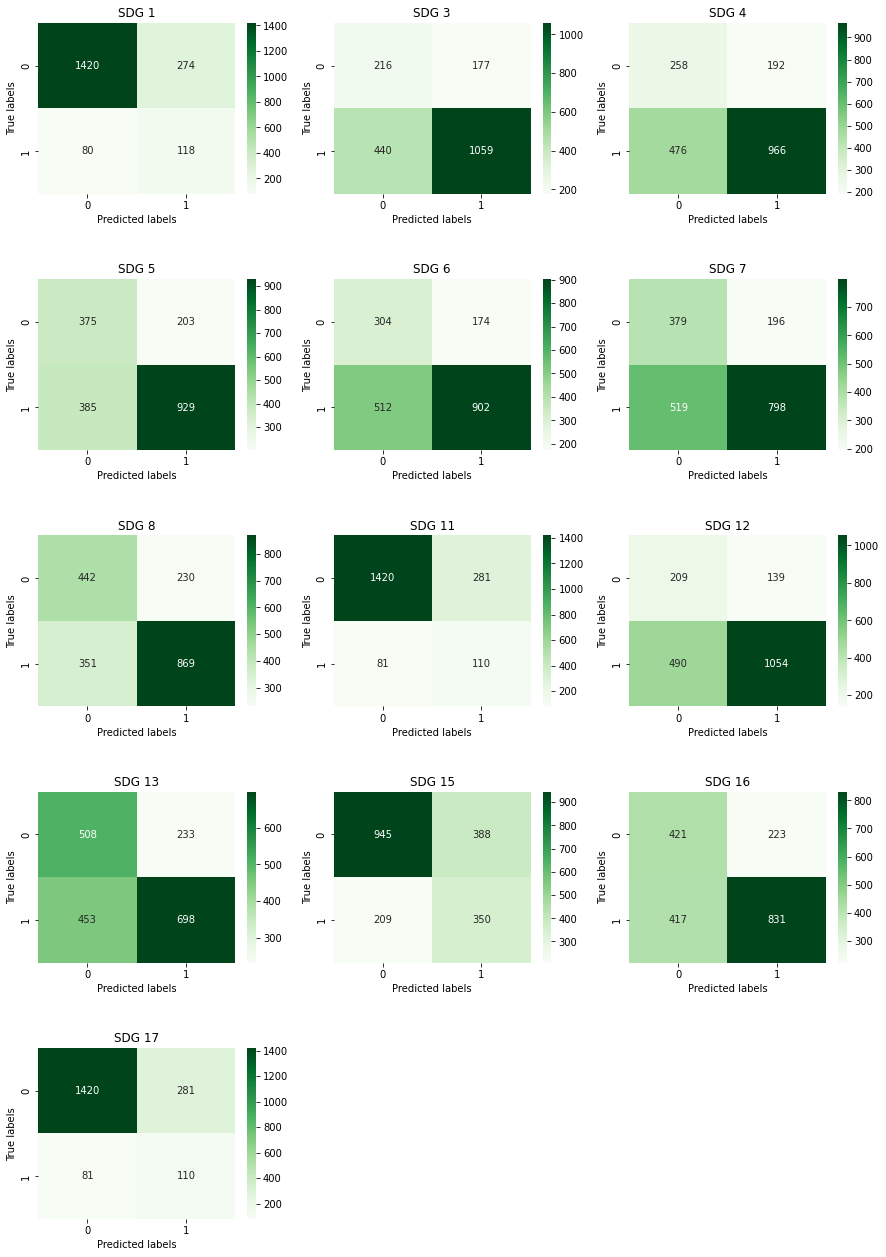

In [14]:
evaluation(clf_balanced, outputs_test, Y_test)

              precision    recall  f1-score   support

           0       0.37      0.75      0.50       198
           1       0.89      0.69      0.78      1499
           2       0.86      0.66      0.75      1442
           3       0.85      0.70      0.76      1314
           4       0.89      0.63      0.74      1414
           5       0.84      0.62      0.71      1317
           6       0.80      0.69      0.74      1220
           7       0.34      0.73      0.47       191
           8       0.93      0.63      0.75      1544
           9       0.80      0.63      0.70      1151
          10       0.57      0.69      0.63       559
          11       0.82      0.65      0.73      1248
          12       0.34      0.73      0.47       191

   micro avg       0.78      0.66      0.72     13288
   macro avg       0.72      0.68      0.67     13288
weighted avg       0.82      0.66      0.73     13288
 samples avg       0.72      0.63      0.63     13288



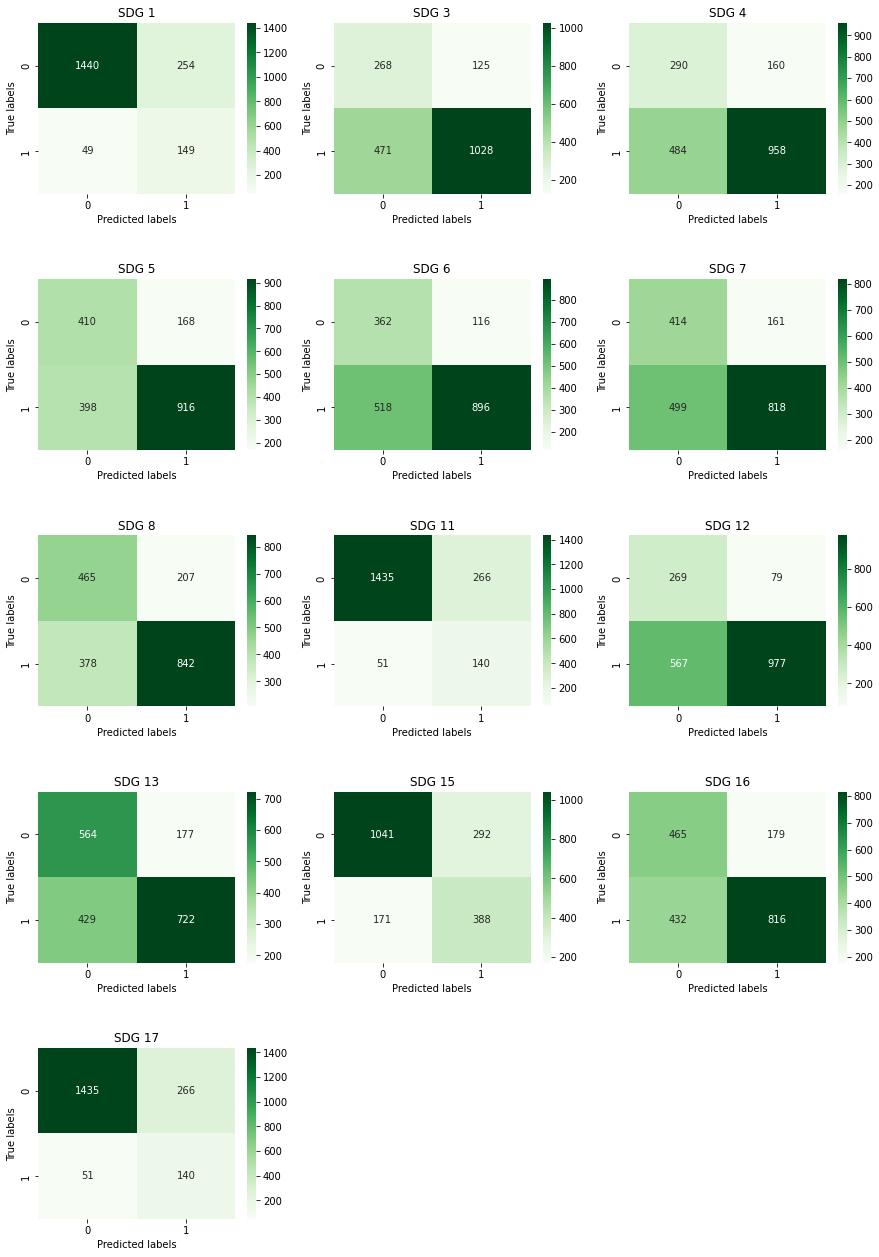

In [18]:
# Evaluation tokenized
evaluation(clf_balanced, outputs_test, Y_test)

### 2.4. Classification with prior balancing of data

In [15]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', LogisticRegression())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
clf_smote = OneVsRestClassifier(pipeline)
clf_smote.fit(outputs_train, Y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('smote', SMOTE()),
                                              ('clf', LogisticRegression())]))

In [17]:
predictions = clf_smote.predict(outputs_test)

              precision    recall  f1-score   support

           0       0.30      0.58      0.40       198
           1       0.85      0.73      0.79      1499
           2       0.82      0.69      0.75      1442
           3       0.81      0.73      0.77      1314
           4       0.83      0.66      0.73      1414
           5       0.80      0.62      0.70      1317
           6       0.79      0.75      0.77      1220
           7       0.29      0.57      0.39       191
           8       0.88      0.71      0.78      1544
           9       0.75      0.61      0.67      1151
          10       0.48      0.62      0.55       559
          11       0.78      0.68      0.73      1248
          12       0.28      0.57      0.38       191

   micro avg       0.75      0.68      0.71     13288
   macro avg       0.67      0.65      0.65     13288
weighted avg       0.78      0.68      0.72     13288
 samples avg       0.72      0.66      0.65     13288



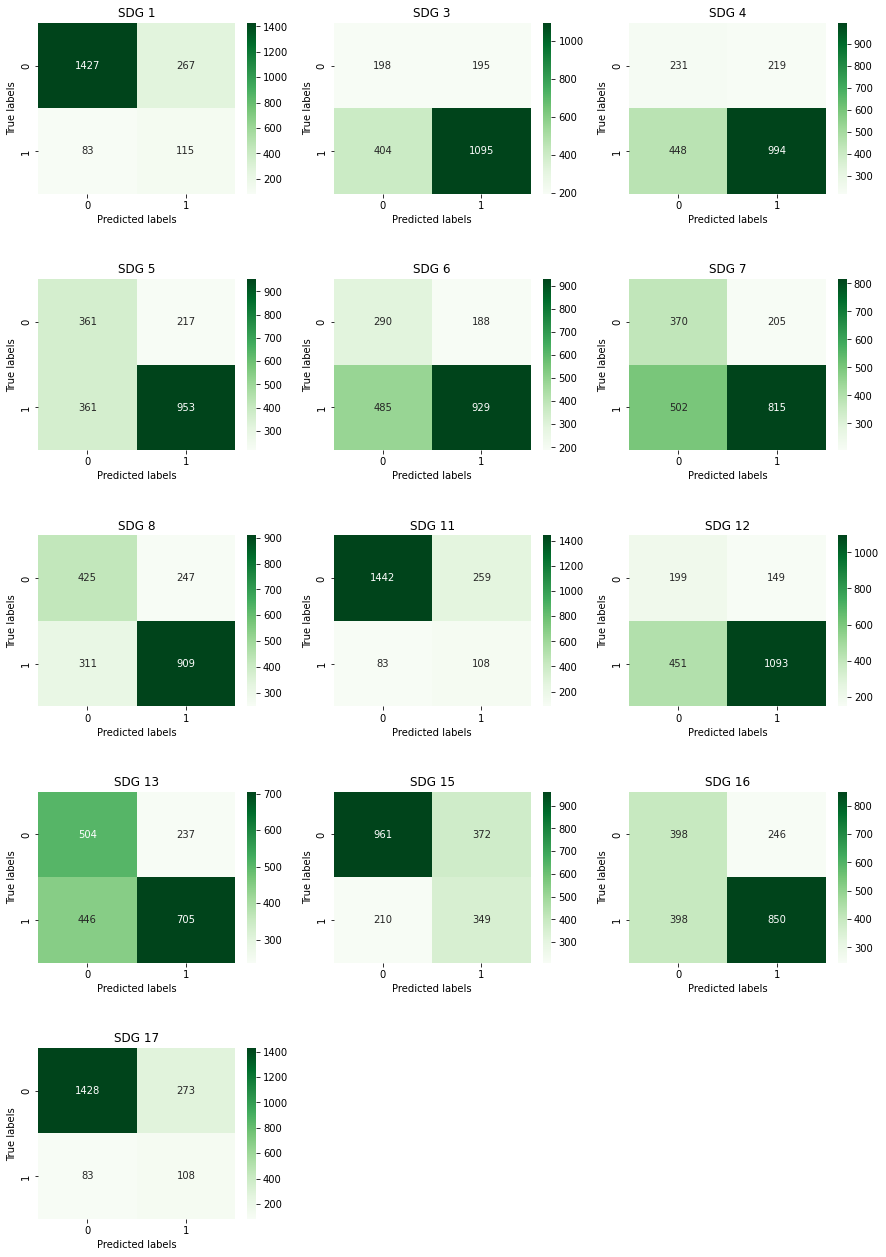

In [16]:
evaluation(clf_smote, outputs_test, Y_test)

              precision    recall  f1-score   support

           0       0.39      0.74      0.51       198
           1       0.89      0.70      0.78      1499
           2       0.85      0.68      0.75      1442
           3       0.85      0.71      0.78      1314
           4       0.87      0.66      0.75      1414
           5       0.83      0.62      0.71      1317
           6       0.81      0.70      0.75      1220
           7       0.36      0.73      0.49       191
           8       0.93      0.64      0.76      1544
           9       0.79      0.63      0.70      1151
          10       0.57      0.67      0.62       559
          11       0.82      0.67      0.74      1248
          12       0.36      0.71      0.48       191

   micro avg       0.79      0.67      0.72     13288
   macro avg       0.72      0.68      0.68     13288
weighted avg       0.82      0.67      0.73     13288
 samples avg       0.73      0.64      0.64     13288



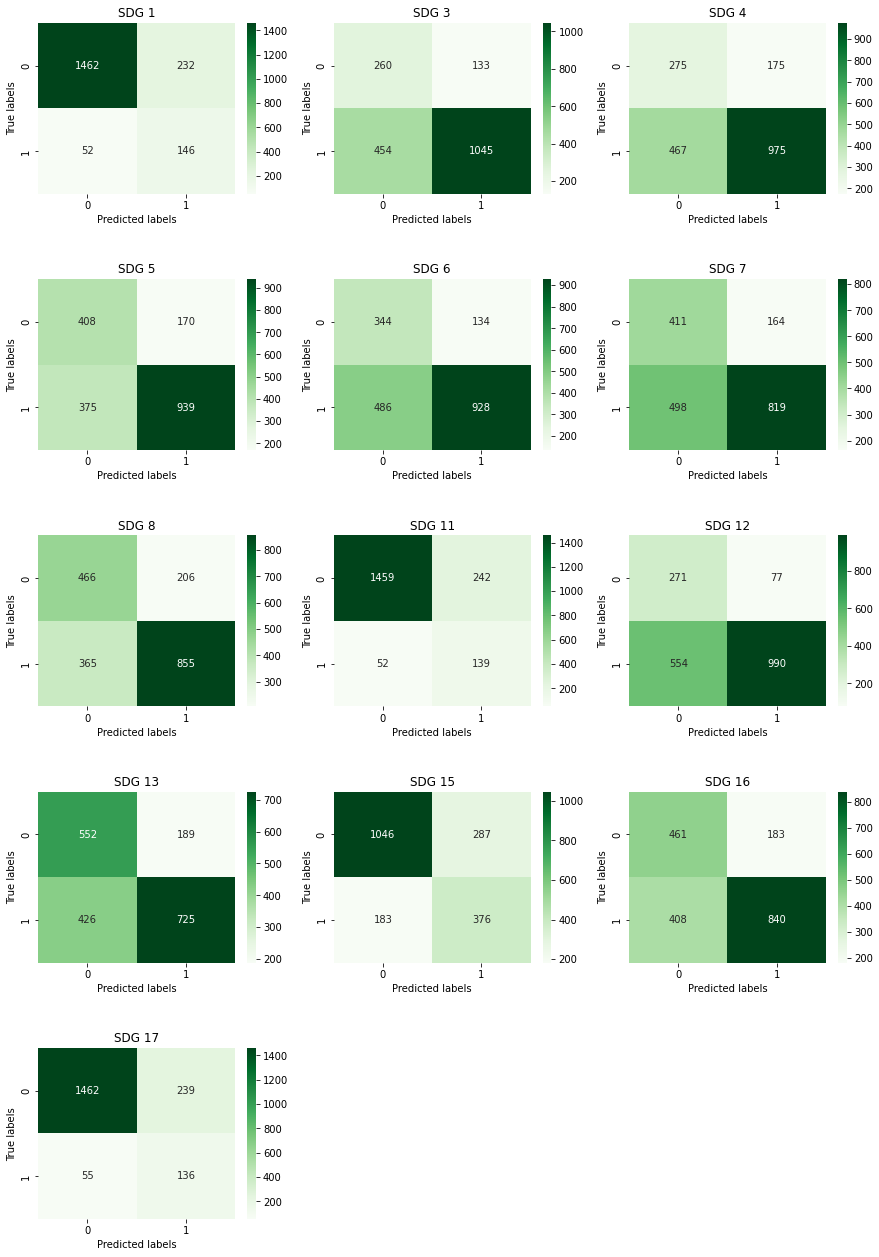

In [20]:
# Evaluation tokenized
evaluation(clf_smote, outputs_test, Y_test)